In [56]:
from collections import deque

import gym
from gym import wrappers, logger

import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np

import matplotlib.pyplot as plt

import copy

In [2]:
SAV = "img/"

In [3]:
def plot_reward(rewards, title="", file_name="error", mean_size=100, type_graph="dot"):
    list_e = []
    x_s = []
    i = 0
    if mean_size < 2:
        list_e = rewards
        x_s = range(len(rewards))
    else:
        while i < len(rewards):
            max_mean = i + mean_size
            if max_mean >= len(rewards):
                max_mean = len(rewards) - 1
            list_e.append(sum(rewards[i:max_mean])/(max_mean - i))
            x_s.append((max_mean + i)/2)
            i += mean_size
    # for error in errors:
    #     list_e.append(error.item())
    plt.figure(figsize=(10, 10))
    if type_graph == "dot":
        plt.plot(x_s, list_e, 'ok')
    else:
        # plt.bar(x_s, list_e)
        plt.plot(list_e, 'k')
    plt.ylabel("Récompense")
    plt.xlabel("Itération")
    plt.title(title)
    if file_name:
        plt.savefig(f"{SAV}{env_name}/{type_graph}_{file_name}.png")
    plt.show()


In [5]:
class Experience:
    def __init__(self, _state, _action, _reward, _next_state, _done):
        self.state = _state
        self.action = _action
        self.reward = _reward
        self.next_state = _next_state
        self.done = _done

In [6]:
env_name = 'CartPole-v1'

In [71]:
class Net(nn.Module):
    def __init__(self, in_size, out_size):
        super(Net, self).__init__()
        print(in_size, out_size)
        # self.in_l = nn.Linear(in_size, out_size)
        self.in_l = nn.Linear(in_size, 3)
        self.in_l2 = nn.Linear(3, out_size)

    def forward(self, x):
        x = F.sigmoid(self.in_l(x))
        x = F.sigmoid(self.in_l2(x))
        return x

In [70]:
class Agent:
    def __init__(self, _net, _in_size, _out_size, _target=None):
        self.mem = deque(maxlen=10000)
        self.net = _net
        self.target = _target
        self.target_nn = _target
        self.gamma = 0.95
        self.in_size = _in_size
        self.out_size = _out_size

    def choose_action(self, _observation, _reward, _done):
        qvalues = self.qvalue(_observation)
        action_ind = self.epsilongreedy(_observation, epsilon=0.05)
        # action_ind = self.boltzmann(_observation, tau=0.1)
        return action_ind

    def experience(self, _state, _action, _reward, _next_state, _done):
        self.mem.append(Experience(_state, _action, _reward, _next_state, _done))

    def minibatch(self, size=5):
        batch_s = min(size, len(self.mem))
        return random.sample(self.mem, batch_s)

    def qvalue(self, state):
        inp = torch.tensor(state).type(torch.FloatTensor)
        out = self.net(inp)
        return out

    def qvalue_target(self, state):
        inp = torch.tensor(state).type(torch.FloatTensor)
        if self.target is not None:
            out = self.target(inp)
        else:
            out = self.net(inp)
        return out

    def epsilongreedy(self, ob, epsilon=0.5):
        if np.random.random() < epsilon:
            return np.random.randint(self.out_size)
        else:
            _, max_ind = self.qvalue(ob).max(0)
            return max_ind.item()

    def boltzmann(self, ob, tau=1000):
        qvalues = self.qvalue(ob)
        terms = torch.pow(np.e, torch.div(qvalues, tau))
        sum_ = terms.sum()
        probs = torch.div(terms, sum_)
        probs = np.array(probs)
        action_value = np.random.choice(probs,p=probs)
        action = np.argmax(probs == action_value)
        return action

    def sync_target(self):
        self.target = copy.deepcopy(self.net)

In [53]:
env.close()

In [74]:
# You can set the level to logger.DEBUG or logger.WARN if you
# want to change the amount of output.
logger.set_level(logger.INFO)

env = gym.make(env_name)

# You provide the directory to write to (can be an existing
# directory, including one with existing data -- all monitor files
# will be namespaced). You can also dump to a tempdir if you'd
# like: tempfile.mkdtemp().
outdir = '/tmp/random-agent-results'
env = wrappers.Monitor(env, directory=outdir, force=True, video_callable=False)
env.seed(0)
observation_size = env.observation_space.shape[0]
action_size = env.action_space.n

eta = 0.01
net = Net(observation_size, env.action_space.n)
target = copy.deepcopy(net)
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=eta, momentum=0.9)
agent = Agent(net, observation_size, env.action_space.n, _target=target)

render = True
episode_count = 10000
episode_render = 1000
reward = 0
batch_size = 5
target_sync = 10000
done = False

rewards = []

INFO: Making new env: CartPole-v1
INFO: Finished writing results. You can upload them to the scoreboard via gym.upload('/tmp/random-agent-results')
INFO: Clearing 2 monitor files from previous run (because force=True was provided)
4 2


In [ ]:
batch_calc = 0
for i in range(episode_count):
    ob = env.reset()
    rewardSum = 0
    steps = 0
    done = False
    while not done:
        with torch.no_grad():
            action = agent.choose_action(ob, reward, done)
        current_state = ob
        if render:
            if i % episode_render == 0:
                env.render()
            elif (i - 1) % episode_render == 0:
                env.close()
        ob, reward, done, _ = env.step(action)
        rewardSum += reward
        steps += 1

        # Experience replay
        agent.experience(current_state, action, reward, ob, done)
        minibatch = agent.minibatch(size=batch_size)
        for batch in minibatch:
            batch_calc += 1
            optimizer.zero_grad()
            with torch.no_grad():
                yj = batch.reward
                if not batch.done:
                    yj += agent.gamma * agent.qvalue_target(batch.next_state).max().item()
            qvalues = agent.qvalue(batch.state)
            real_y = qvalues.clone()
            new_q = (qvalues[batch.action].item() - yj) ** 2
            real_y[batch.action] = new_q
            loss = criterion(qvalues, real_y)
            loss.backward()
            optimizer.step()
            if batch_calc % target_sync == 0:
                agent.sync_target()
        if done:
            print(f"ep {i} : reward {rewardSum}", end="\r")
            rewards.append(rewardSum)




INFO: Finished writing results. You can upload them to the scoreboard via gym.upload('/tmp/random-agent-results')


INFO: Finished writing results. You can upload them to the scoreboard via gym.upload('/tmp/random-agent-results')
INFO: Finished writing results. You can upload them to the scoreboard via gym.upload('/tmp/random-agent-results')


In [ ]:
env.close()
rewards

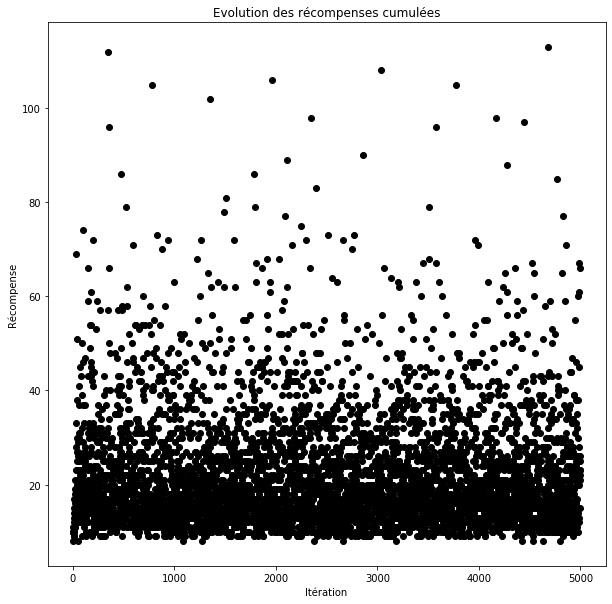

In [49]:
plot_reward(rewards, "Evolution des récompenses cumulées", file_name=f"{episode_count}_{batch_size}_e{len(rewards)}_eta{eta}_target", mean_size=1, type_graph="dot")

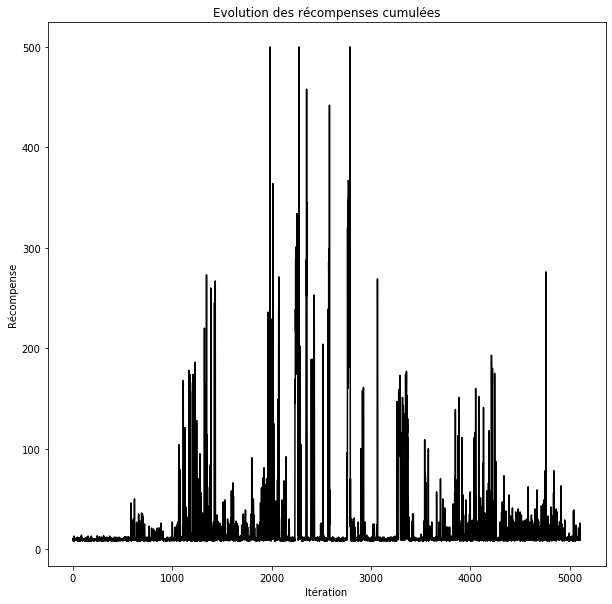

In [42]:
plot_reward(rewards, "Evolution des récompenses cumulées", file_name=f"{episode_count}_{batch_size}_e{len(rewards)}_eta{eta}_target", mean_size=1, type_graph="bar")